In [ ]:
import os 
import pandas as pd
import numpy as np 
import seaborn as sns
from PIL import Image 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import cv2
import random

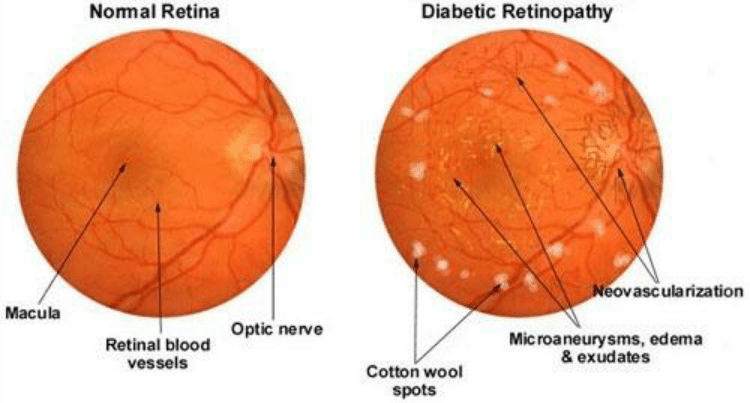

0 - No DR

1 - Mild

2 - Moderate

3 - Severe

4 - Proliferative DR

In [ ]:
label_dic = {
    "0":"No DR",
    "1" : "Mild",
    "2":"Moderate",
    "3":"Severe",
    "4":"Proliferative DR"
}

In [ ]:
df_train = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')
df_test = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/test.csv')

In [ ]:
print("Training Data Shape : ",df_train.shape)
print("Test Data Shape : ",df_test.shape)

In [ ]:
df_train.head()

In [ ]:
#Check Some Samples and Their Label

rows=3
cols = 2
count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15,15))

indx = random.sample(range(df_train.shape[0]),rows * cols)

for i in range(rows):
    for j in range(cols):        
        if count < len(indx):
            img_path = "/kaggle/input/aptos2019-blindness-detection/train_images/"+df_train.iloc[indx[count],0]+".png"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i,j].set_title(label_dic[str(df_train.iloc[indx[count],1])])
            count+=1
            

Infos About the DATASET

In [ ]:
df_train.diagnosis.value_counts()

In [ ]:
sns.countplot(x=df_train['diagnosis'])

# Image Processing 

**Canny Edge Detector**

In [ ]:
rn_idx = indx = random.randint(0,df_train.shape[0])
img = cv2.imread("/kaggle/input/aptos2019-blindness-detection/train_images/"+df_train.id_code.iloc[rn_idx]+".png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)
# Setting parameter values
t_lower = 1  # Lower Threshold
t_upper = 50  # Upper threshold
  
# Applying the Canny Edge filter
edge = cv2.Canny(img, t_lower, t_upper)
f, ax = plt.subplots(1,2,figsize = (11,11))
ax[0].imshow(img_gray,cmap='gray')
ax[1].imshow(edge,cmap='gray')
plt.title('Edges')
plt.show()

**Guassian Blur**

In [ ]:
rn_idx = indx = random.randint(0,df_train.shape[0])
img = cv2.imread("/kaggle/input/aptos2019-blindness-detection/train_images/"+df_train.id_code.iloc[rn_idx]+".png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

f, ax = plt.subplots(1,2,figsize = (11,11))
ax[0].imshow(img)
ax[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

We notice that the retine position in most of images are not the same a thing that can misslad the training so we will apply a circular crop to make all the images look in the same way and focus more on the features

In [ ]:
def crop_image_from_gray(img,low_bound=7):
    if img.ndim ==2:
        mask = img>low_bound
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>low_bound
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [ ]:
img = crop_image_from_gray(img)
plt.imshow(img)

In [ ]:
def circle_crop(img, sigmaX=30):   
    """
    Create circular crop around image centre    
    """    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

In [ ]:
img = circle_crop(img)
plt.imshow(img)

After Transformation Sample

In [ ]:
rows=4
cols = 5
count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

indx = random.sample(range(df_train.shape[0]),rows * cols)

for i in range(rows):
    for j in range(cols):        
        if count < len(indx):
            img_path = "/kaggle/input/aptos2019-blindness-detection/train_images/"+df_train.iloc[indx[count],0]+".png"
            img = cv2.imread(img_path)
            img = crop_image_from_gray(img)
            img = circle_crop(img)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i,j].set_title(label_dic[str(df_train.iloc[indx[count],1])])
            count+=1
            

# TSNE